# Evaluate water mass properties on the shelves using Shenjie's climatology

In [13]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as cl
import cmocean
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import glob
import sys
sys.path.append('/home/users/birgal/')

from nemo_python_git.file_io import read_dutrieux, read_zhou, read_schmidtko, read_woa
from nemo_python_git.utils import convert_to_teos10, distance_btw_points, closest_point
from nemo_python_git.interpolation import interp_latlon_cf
from nemo_python_git.plots import circumpolar_plot, finished_plot

In [14]:
base_dir = '/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/'
run_folder    = f'{base_dir}output/ERA5_test4_cont/'
nemo_mesh     = f'{base_dir}bathymetry/mesh_mask-20240305.nc'
nemo_domain   = f'{base_dir}bathymetry/domain_cfg-20240305.nc'

## Look at Shenjie Zhou's observational dataset
- create an evaluation of the specified depth slice circumpolar for simulation and observations

In [30]:
# Compare temperature and salinity in a depth range in NEMO (time-averaged over the given xarray Dataset) to observations: 
# Specifically, Shenji Zhou's 2024 dataset
def circumpolar_TS_vs_obs (nemo, depth_min, depth_max, nemo_mesh='/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/bathymetry/mesh_mask-20240305.nc'):
    xr.set_options(file_cache_maxsize=1)
    
    # depth is the depth to look at (could be a slice):
    print('Reading in observations')
    obs       = read_zhou()
    obs_zhou  = obs.drop(['pressure', 'lon', 'lat', 'depth']).rename_dims({'y':'lat', 'x':'lon'})
    # obs_zhou  = obs_zhou.where((abs(obs.depth) > depth_min) * (abs(obs.depth) <= depth_max)).mean(dim='z')
    obs_zhou  = obs_zhou.isel(z=0)
    obs_zhou  = obs_zhou.assign_coords({'lat':obs.lat.isel(x=0).values, 'lon':obs.lon.isel(y=0).values}).transpose()
    # Regrid to the NEMO grid
    nemo_plot = xr.Dataset({'ConsTemp':nemo['thetao'].isel(deptht=0), 'AbsSal':nemo['so'].isel(deptht=0)})
    # nemo_plot = nemo_plot.isel(deptht=0) #nemo_plot.where((nemo_plot.deptht > depth_min) * (nemo_plot.deptht <= depth_max)).mean(dim='deptht')
    print('Interpolating Zhou 2024 dataset to grid')
    obs_plot  = interp_latlon_cf(obs_zhou, nemo_plot, method='bilinear')
    # nemo_plot = nemo_plot.rename({'x_grid_T':'x', 'y_grid_T':'y'})
    print('finished interpolation')

    nemo_plot = nemo_plot.where(nemo_plot['ConsTemp']!=0) # Apply NEMO land mask to both
    obs_plot  = obs_plot.where(nemo_plot['ConsTemp'].notnull()*obs_plot.notnull())
    obs_plot  = obs_plot.where(nemo_plot['ConsTemp']!=0)
    nemo_plot = nemo_plot.where(nemo_plot['ConsTemp']!=0)
    print('finished land masking')
    print(nemo_plot, obs_plot)
    # Get difference from obs
    bias = nemo_plot - obs_plot

    print('Creating figure')
   # Make the plot
    fig = plt.figure(figsize=(10,7))
    gs = plt.GridSpec(2,3)
    gs.update(left=0.1, right=0.9, bottom=0.05, top=0.95, hspace=0.2, wspace=0.1)
    data_plot = [nemo_plot, obs_plot, bias]
    var_plot = ['ConsTemp', 'AbsSal']
    # var_titles = ['Bottom temperature ('+deg_string+'C)', 'Bottom salinity ('+gkg_string+')']
    var_titles = ['Temperature', 'Salinity']
    alt_titles = [None, 'Observations', 'Model bias']
    vmin = [-2, -2, -0.5, 32.5, 32.5, -0.2]
    vmax = [2, 2, 0.5, 34, 34, 0.2]
    ctype = ['RdBu_r', 'RdBu_r', 'plusminus']
    i=0
    for v in range(2):
        for n in range(3):
            ax = plt.subplot(gs[v,n])
            ax.axis('equal')
            img = circumpolar_plot(data_plot[n][var_plot[v]], nemo, ax=ax, masked=True, make_cbar=False, 
                                   title=(var_titles[v] if n==0 else alt_titles[n]), 
                                   vmin=vmin[i], vmax=vmax[i], ctype=ctype[n], shade_land=False)
            i+=1
            if n != 1:
                cax = fig.add_axes([0.01+0.46*n, 0.58-0.48*v, 0.02, 0.3])
                plt.colorbar(img, cax=cax, extend='both' if n==0 else 'neither')
    
    # finished_plot(fig, fig_name=fig_name, dpi=dpi)

In [37]:
file_list = glob.glob(f'{run_folder}files/eANT025.L121_1m_20*_grid_T*.nc')
sim    = xr.open_mfdataset(file_list)
# sim    = xr.open_dataset(file_list[10]).isel(time_counter=0)
sim    = sim.isel(time_counter=(sim.time_counter.dt.month==1)).mean(dim='time_counter')
sim_ds = sim.rename({'x_grid_T':'x', 'y_grid_T':'y', 'area_grid_T':'area', 'e3t':'thkcello',
                     'nav_lon_grid_T':'nav_lon', 'nav_lat_grid_T':'nav_lat',
                     'bounds_nav_lon_grid_T':'bounds_lon', 'bounds_nav_lat_grid_T':'bounds_lat',
                     'nvertex_grid_T':'nvertex'})

sim_ds = sim_ds.drop(['area', 'deptht_bounds', 'zos', 'mldr10_1', 'sbt', 'sbs', 'sosst', 'sosss', 'thkcello']) #, 
                      # 'time_centered_bounds', 'time_counter_bounds'])

In [ ]:
circumpolar_TS_vs_obs(sim_ds, 400, 500)

Reading in observations
Interpolating Zhou 2024 dataset to grid


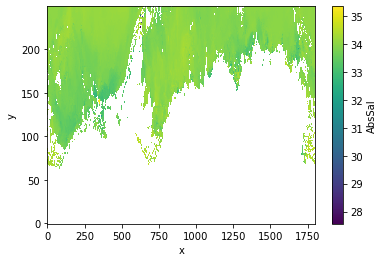

In [21]:
obs.AbsSal.isel(z=0, y=slice(50,300)).plot(x='x', y='y')

In [46]:
obsd = read_dutrieux(eos='teos10')

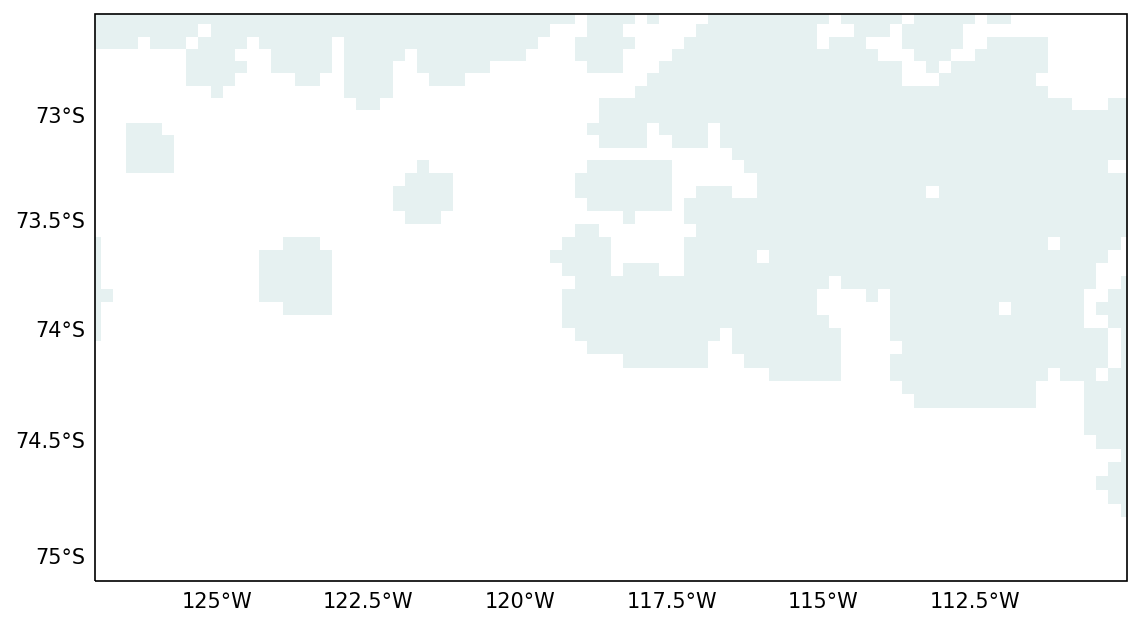

In [66]:
fig, ax = plt.subplots(1,1, figsize=(10,5), dpi=150, subplot_kw={'projection': ccrs.Mercator(latitude_true_scale=-70)})
ax.set_extent([-110, -127, -75.1, -72.5], ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True);
gl.xlines=None; gl.ylines=None; gl.top_labels=None; gl.right_labels=None;

obs_plt = obsd.isel(depth=100)
kwags = {'cmap':cmocean.cm.dense, 'vmin':0.2, 'vmax':1.0}
lonp, latp = np.meshgrid(obsd.lon.values, obsd.lat.values)
ax.pcolormesh(lonp, latp, obs_plt.ConsTemp.values, transform=ccrs.PlateCarree(), rasterized=True, **kwags)

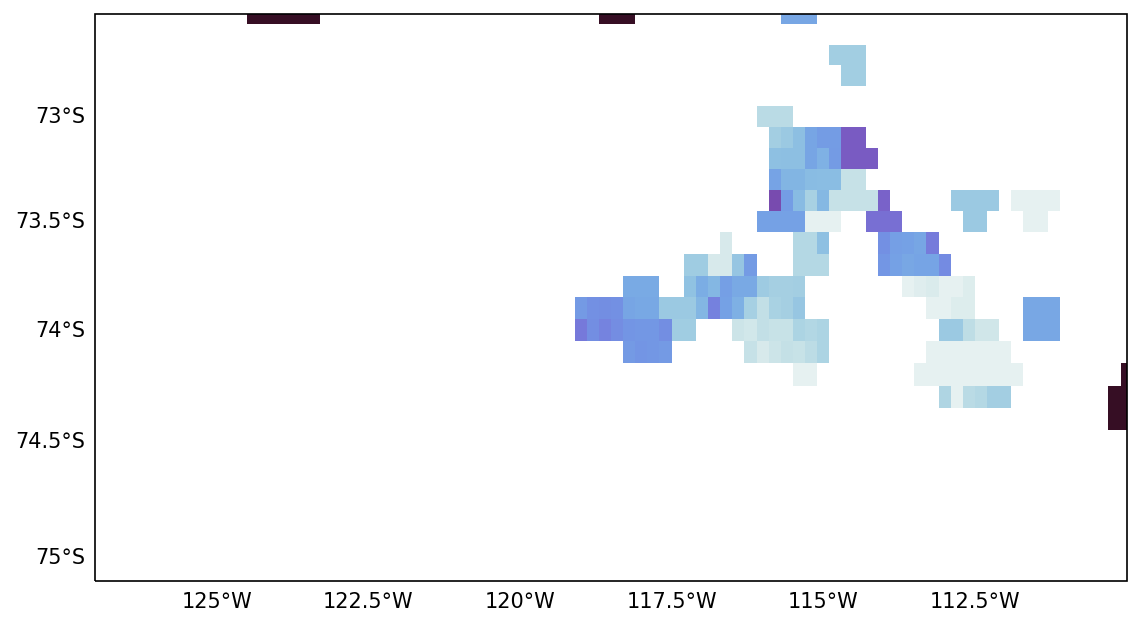

In [44]:
fig, ax = plt.subplots(1,1, figsize=(10,5), dpi=150, subplot_kw={'projection': ccrs.Mercator(latitude_true_scale=-70)})
ax.set_extent([-110, -127, -75.1, -72.5], ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True);
gl.xlines=None; gl.ylines=None; gl.top_labels=None; gl.right_labels=None;

obs_plt = obs.isel(z=70, x=slice(100,450), y=slice(100,250))
kwags = {'cmap':cmocean.cm.dense, 'vmin':0.2, 'vmax':1.0}
ax.pcolormesh(obs_plt.lon.values, obs_plt.lat.values, obs_plt.ConsTemp.values, transform=ccrs.PlateCarree(), rasterized=True, **kwags)

In [5]:
# extract the bottom temperatures and salinities 
depth_bottom_obs = xr.where(obs['ConsTemp'].notnull(),obs['depth'],np.nan).max(dim='z')
depth_bottom_obs = xr.where(depth_bottom_obs < 200, np.nan, depth_bottom_obs) # mask areas shallower than 200 m
bottom_Tobs      = obs['ConsTemp'].where(~np.isnan(depth_bottom_obs)).mean(dim='z')
bottom_Sobs      = obs['AbsSal'].where(~np.isnan(depth_bottom_obs)).mean(dim='z')

obs_bottom = xr.Dataset({'temp':bottom_Tobs, 'salt':bottom_Sobs, 'depth':depth_bottom_obs})

In [6]:
# load nemo grid for interpolation
nemo_ds_ref  = xr.open_dataset(f'{run_folder}eANT025.L121_1m_19790101_19791231_grid_T.nc') # load all the gridT files in the run folder
nemo_ds_ref  = nemo_ds_ref.rename({'e3t':'thkcello', 'x_grid_T':'x', 'y_grid_T':'y', 'area_grid_T':'area', 'e3t':'thkcello',
                          'nav_lon_grid_T':'nav_lon', 'nav_lat_grid_T':'nav_lat', 
                          'bounds_nav_lon_grid_T':'bounds_lon', 'bounds_nav_lat_grid_T':'bounds_lat',
                          'nvertex_grid_T':'nvertex'})

In [ ]:
obs_interp = interp_latlon_cf(obs_bottom, nemo_ds_ref.isel(x=slice(450, 900), y=slice(130,350)), method='bilinear')

## Also look at moorings:

In [5]:
files = glob.glob('/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/observations/shenjie-zhou/mooring/*.nc')

In [30]:
mooring1  = xr.open_dataset(files[0], decode_times=False).squeeze()
mooring2  = xr.open_dataset(files[1], decode_times=False).squeeze()
mooring10 = xr.open_dataset(files[10], decode_times=False).squeeze()

In [31]:
list(mooring10.keys())

['lat',
 'lon',
 'bottom_depth',
 'doi',
 'Instrument_01_date',
 'Instrument_01_depth',
 'Instrument_01_press',
 'Instrument_01_temp',
 'Instrument_01_u',
 'Instrument_01_v',
 'Instrument_02_date',
 'Instrument_02_depth',
 'Instrument_02_press',
 'Instrument_02_temp',
 'Instrument_02_u',
 'Instrument_02_v']

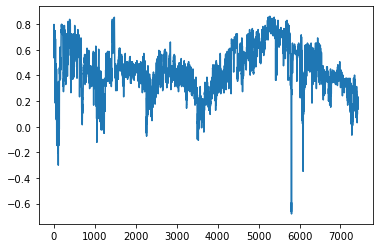

In [34]:
plt.plot(mooring10.Instrument_01_temp.values)

In [15]:
a = xr.open_dataset('/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/observations/pierre-dutrieux/110036.nc').squeeze()